In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [19]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [20]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return Q, target_policy

In [21]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(21, 6, False): array([ 0., -1.])})
defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(21, 6, False): array([ 0., -1.]), (14, 7, False): array([-1.,  0.])})
defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(21, 6, False): array([ 0., -1.]), (17, 10, False): array([-1.,  0.]), (14, 7, False): array([-1.,  0.])})
defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(21, 6, False): array([ 0., -1.]), (17, 10, False): array([-1.,  0.]), (14, 7, False): array([-1.,  0.]), (14, 7, True): array([-1.,  0.])})
defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(21, 6, False): array([ 0., -1.]), (17, 3, False): array([ 0., -1.]), (17, 10, False): array([-1.,  0.]), (14, 7, False): array([-1.,  0.]), (14, 7, True): array([-1

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(21, 5, True): array([ 0.,  0.]), (17, 3, False): array([ 0., -1.]), (15, 3, False): array([ 0.,  1.]), (17, 6, False): array([ 0., -1.]), (12, 5, False): array([-1.,  0.]), (15, 1, False): array([ 0., -1.]), (12, 2, False): array([-1.,  0.]), (18, 1, False): array([ 0., -1.]), (15, 8, False): array([-1.,  0.]), (21, 3, False): array([ 1.,  0.]), (16, 10, False): array([-1., -1.]), (15, 5, False): array([ 0., -1.]), (20, 10, False): array([ 1., -1.]), (14, 7, False): array([-1., -1.]), (21, 6, False): array([ 0., -1.]), (12, 4, False): array([-1.,  0.]), (14, 7, True): array([-1.,  0.]), (19, 10, False): array([ 1., -1.]), (13, 10, False): array([ 0., -1.]), (20, 7, False): array([ 1.,  0.]), (17, 10, False): array([-1., -1.]), (18, 8, False): array([ 0.,  0.]), (21, 4, True): array([ 1.,  0.]), (16, 3, False): array([ 1.,  0.]), (20, 4, False): array([ 0., -1.]), (14, 4, True): array([ 0., 

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([ 0., -1.]), (17, 6, False): array([ 0., -1.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0.,  0.]), (14, 1, False): array([ 0., -1.]), (18, 1, False): array([ 0., -1.]), (12, 10, False): array([ 0. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (16, 10, False): array([ -1.00000000e+00,  -5.55111512e-17]), (14, 2, False): array([ 1.,  0.]), (21, 4, True): array([ 1.,  0.]), (18, 2, False): array([ 1.,  0.]), (21, 4, False): array([ 0., -1.]), (21, 6, False): array([ 0., -1.]), (15, 10, False): array([ 1., -1.]), (17, 2, True): array([-1.,  0.]), (19, 10, False): array([ 1., -1.]), (18, 7, False): array([ 1., -1.]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([ 0., -1.]), (20, 7, False): array([ 1.,  0.]), (18, 7, True): array([ 0.,  1.]), (17, 10, False): array([-1., -1.]), (18, 8, False): array([ 0.,  0.]), (17, 10, True): array([ 1.,  0.])

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([ 0., -1.]), (15, 4, False): array([ 0., -1.]), (14, 4, False): array([-1.,  0.]), (17, 6, False): array([ 0., -1.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0.,  0.]), (14, 3, False): array([ 1.,  0.]), (14, 1, False): array([ 0.        ,  0.33333333]), (16, 10, True): array([-1.,  0.]), (18, 1, False): array([ 0.        ,  0.33333333]), (12, 10, False): array([ 0. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (16, 10, False): array([-1. , -0.2]), (14, 2, False): array([ 1.,  0.]), (21, 4, True): array([ 1.,  0.]), (18, 2, False): array([ 1.,  0.]), (21, 4, False): array([ 0., -1.]), (21, 6, False): array([ 0., -1.]), (15, 10, False): array([ 0., -1.]), (17, 2, True): array([-1.,  0.]), (19, 10, False): array([ 1., -1.]), (18, 7, False): array([ 1., -1.]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([-1., -1.]), (20, 7, False): array([ 1

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([ 0., -1.]), (15, 4, False): array([ 1., -1.]), (14, 4, False): array([-1.,  0.]), (17, 6, False): array([ 0., -1.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0.,  0.]), (14, 3, False): array([ 1.,  0.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 10, True): array([-1.,  0.]), (18, 1, False): array([ 0.        ,  0.33333333]), (12, 10, False): array([ 0. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (16, 10, False): array([-1. , -0.2]), (14, 2, False): array([ 1.,  0.]), (21, 4, True): array([ 1.,  0.]), (18, 2, False): array([ 1.,  0.]), (21, 4, False): array([ 0., -1.]), (21, 6, False): array([ 0., -1.]), (15, 10, False): array([-0.5, -1. ]), (12, 1, False): array([ 0.,  1.]), (17, 2, True): array([-1.,  0.]), (19, 10, False): array([ 1., -1.]), (18, 7, False): array([ 1., -1.]), (17, 5, False): array([ 

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([ 0., -1.]), (15, 4, False): array([ 1., -1.]), (14, 4, False): array([-1.,  0.]), (17, 6, False): array([ 0., -1.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0.,  0.]), (14, 3, False): array([ 1.,  0.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 10, True): array([-1.,  0.]), (18, 1, False): array([ 0.        ,  0.33333333]), (12, 10, False): array([ 0. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (16, 10, False): array([-1. , -0.2]), (14, 2, False): array([ 1.,  0.]), (21, 4, True): array([ 1.,  0.]), (18, 2, False): array([ 1.,  0.]), (21, 4, False): array([ 0., -1.]), (21, 6, False): array([ 0., -1.]), (15, 10, False): array([-0.2, -1. ]), (12, 1, False): array([ 0.,  1.]), (17, 2, True): array([-1.,  0.]), (19, 10, False): array([ 1., -1.]), (18, 7, False): array([ 0.        ,  0.33333333]), (17, 5, 

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([ 0.        ,  0.33333333]), (15, 4, False): array([ 1., -1.]), (14, 4, False): array([-1.,  0.]), (17, 6, False): array([ 0., -1.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0., -1.]), (14, 3, False): array([ 1.,  0.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 10, True): array([-1.,  0.]), (18, 1, False): array([ 0.        ,  0.33333333]), (12, 10, False): array([ 0. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (16, 10, False): array([-1. , -0.2]), (14, 2, False): array([ 1.,  0.]), (21, 4, True): array([ 1.,  0.]), (18, 2, False): array([ 1.,  0.]), (21, 4, False): array([ 0., -1.]), (21, 6, False): array([ 0., -1.]), (15, 10, False): array([-0.2, -1. ]), (18, 3, False): array([ 0.,  0.]), (12, 1, False): array([ 0.,  1.]), (17, 2, True): array([-1.,  0.]), (19, 10, False): array([ 0.33333333, -1.    

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([  0.00000000e+00,  -5.55111512e-17]), (14, 4, False): array([-1.,  0.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0., -1.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 7, False): array([ 0.,  0.]), (12, 10, False): array([-1. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (14, 2, False): array([ 1.,  0.]), (21, 6, False): array([ 0., -1.]), (12, 6, False): array([ 1.,  0.]), (19, 10, False): array([ 0.33333333, -1.        ]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([-1., -1.]), (19, 9, False): array([ 0.,  0.]), (19, 4, False): array([ 0., -1.]), (17, 3, False): array([ 0., -1.]), (21, 8, False): array([ 1.,  0.]), (18, 3, False): array([ 0.,  0.]), (14, 9, False): array([-1.,  0.]), (16, 8, False): array([-1.,  0.]), (14, 10, True): array([ 0.,  1.]), (12, 2, False): array([ 0.33333333, 

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([  0.00000000e+00,  -5.55111512e-17]), (14, 4, False): array([-1.,  0.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0., -1.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 7, False): array([ 0.,  0.]), (12, 10, False): array([-1. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (14, 2, False): array([ 0.33333333,  0.        ]), (21, 6, False): array([ 0., -1.]), (12, 6, False): array([ 1.,  0.]), (19, 10, False): array([ 0.33333333, -1.        ]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([-1., -1.]), (19, 9, False): array([ 0.,  0.]), (19, 4, False): array([ 0., -1.]), (17, 3, False): array([ 0., -1.]), (21, 8, False): array([ 1.,  0.]), (18, 3, False): array([ 0.,  0.]), (14, 9, False): array([-1.,  0.]), (19, 3, False): array([ 0.,  0.]), (16, 8, False): array([-1., -1.]), (14, 10, True): arra

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([  0.00000000e+00,  -5.55111512e-17]), (14, 4, False): array([-1.,  0.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0., -1.]), (13, 1, False): array([ 0., -1.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 7, False): array([ 0.,  0.]), (12, 10, False): array([-1. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (14, 2, False): array([ 0.33333333,  0.        ]), (21, 6, False): array([ 0., -1.]), (12, 6, False): array([ 1.,  0.]), (19, 10, False): array([ 0.33333333, -1.        ]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([-1., -1.]), (19, 9, False): array([ 0.,  0.]), (19, 4, False): array([ 0., -1.]), (17, 3, False): array([ 0., -1.]), (21, 8, False): array([ 1.,  0.]), (18, 3, False): array([ 0.,  0.]), (14, 9, False): array([-1.,  0.]), (19, 3, False): array([ 0., -1.]), (16, 8, False): arra

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([  0.00000000e+00,  -5.55111512e-17]), (14, 4, False): array([-1.,  0.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0., -1.]), (13, 1, False): array([ 0., -1.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 7, False): array([ 0.,  0.]), (12, 10, False): array([-1. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (14, 2, False): array([ 0.33333333,  0.        ]), (21, 6, False): array([ 0., -1.]), (12, 6, False): array([ 1.,  0.]), (19, 10, False): array([ 0.25, -1.  ]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([-0.33333333, -1.        ]), (19, 9, False): array([ 0.,  0.]), (19, 4, False): array([ 0., -1.]), (17, 3, False): array([ 0., -1.]), (21, 8, False): array([ 1.,  0.]), (18, 3, False): array([ 0.,  0.]), (14, 9, False): array([-1.,  0.]), (19, 3, False): array([ 0.5, -1. ]), (16, 8, False)

defaultdict(<function mc_control_importance_sampling.<locals>.<lambda> at 0x0000018027C75840>, {(17, 8, False): array([  0.00000000e+00,  -5.55111512e-17]), (14, 4, False): array([-1.,  0.]), (20, 6, False): array([ 0., -1.]), (12, 5, False): array([ 0., -1.]), (13, 1, False): array([-1., -1.]), (14, 1, False): array([-1.        ,  0.33333333]), (16, 7, False): array([ 0.,  0.]), (12, 10, False): array([-1. ,  0.6]), (21, 3, False): array([ 1.,  0.]), (13, 4, False): array([ 0., -1.]), (14, 2, False): array([ 0.33333333,  0.        ]), (21, 6, False): array([ 0., -1.]), (12, 6, False): array([ 1.,  0.]), (19, 10, False): array([ 0.25, -1.  ]), (15, 7, False): array([ 0., -1.]), (17, 5, False): array([ 0., -1.]), (13, 10, False): array([-0.33333333, -1.        ]), (19, 9, False): array([ 0.,  0.]), (17, 3, True): array([-1.,  0.]), (19, 4, False): array([ 1., -1.]), (19, 3, True): array([ 1.,  0.]), (17, 3, False): array([ 0., -1.]), (21, 8, False): array([ 1.,  0.]), (18, 3, False): ar

KeyboardInterrupt: 

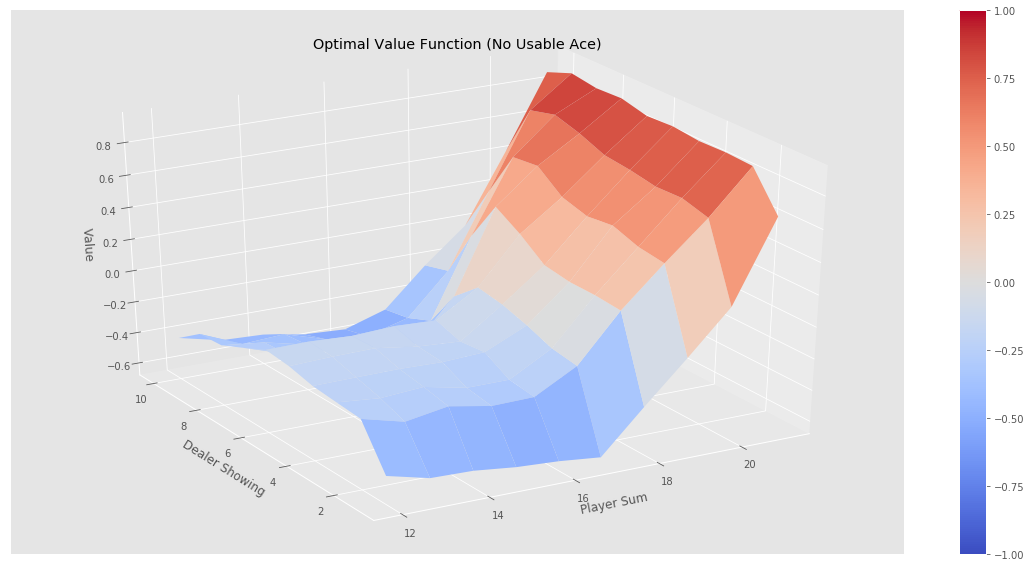

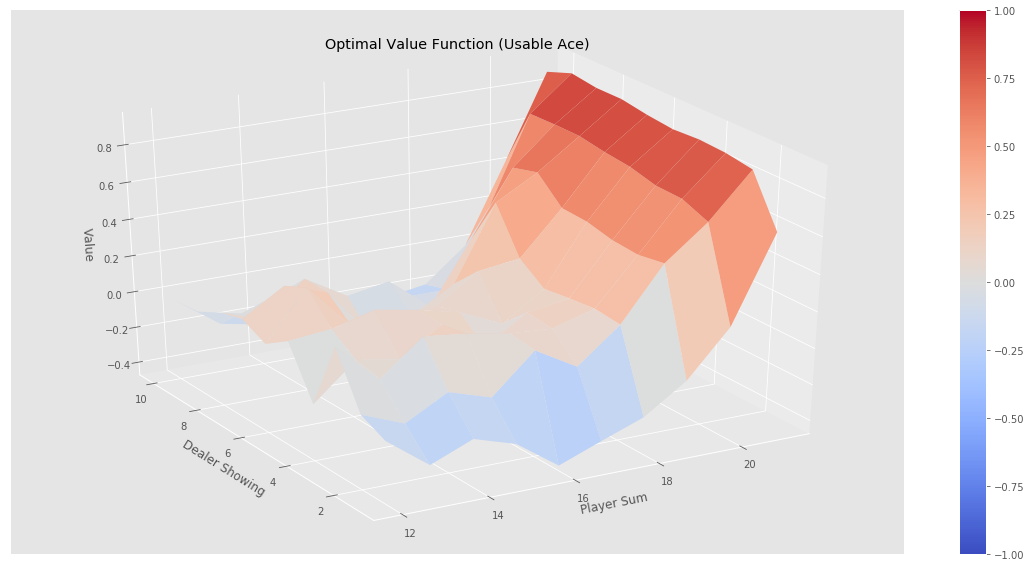

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")